# Visualize Forecasts
This notebook visualizes the forecasts used as input for the optimization problem.

### Imports 

In [1]:
import os
import sys
sys.path.append('..')
from optimization.input_data import load_forecasts, load_params, preprocess_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from optimization.utils import cdf_formula, pdf_formula
from optimization.results_processing import custom_x_axis_formatter
from scipy.integrate import quad

### Load Data

In [2]:
# Example 1: Normal distribution
# fc_folder = '../data/parametric_forecasts/normal_dist_forecast_2025-03-21/'
# params_path = '../data/parameters/params_normal_dist.json'
# timeframe = ['2017-05-18 06:00:00', '2017-05-19 05:00:00']

# Example 2: Sum of two logistic distributions (reproduce paper results)
fc_folder = '../data/parametric_forecasts/gmm2_forecast_2025-03-20_WindowSize5_patch_tst_prosumption_10_03_2025/' 
params_path = '../data/parameters/params_gmm2_case2.json'
timeframe = ['2017-05-18 06:00:00', '2017-05-19 05:00:00']


# Load data
forecasts = load_forecasts(fc_folder, timeframe)
params = load_params(params_path)
input_data = preprocess_data(forecasts, params)

gt = pd.read_csv('../data/ground_truth/residential4_prosumption.csv', index_col=0)
gt.index = pd.to_datetime(gt.index)
if timeframe is not None:
    gt = gt.loc[timeframe[0]:timeframe[1]]

### Plot Expected Prosumption


In [3]:
fc_exp = input_data['fc_exp']
gt_series = gt.iloc[:,0]

# Create the figure
fig = go.Figure()

# Add the line plot
fig.add_trace(go.Scatter(x=fc_exp.index, y=fc_exp.values, mode='lines', name='Expected Prosumption'))
fig.add_trace(go.Scatter(x=gt_series.index, y=gt_series.values, mode='lines', name='Ground truth'))

# Update layout for better visualization
fig.update_layout(
    title='Expected Prosumption vs Ground Truth',
    xaxis_title='Time',
    yaxis_title='Prosumption [kWh]',
    xaxis=dict(
        tickformat='%H:%M',
        tickmode='auto',
        nticks=12,  # Reduce the number of ticks to make the plot more compact
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    annotations=[
        dict(
            xref='paper', yref='paper', x=0.05, y=0.95,
            text="Positive prosumption refers to power consumption.",
            showarrow=False,
            bordercolor='black',
            borderwidth=1,
            borderpad=4,
            bgcolor='white',
            opacity=0.8
        )
    ],
    width=800,  # Adjust the width of the plot
    height=500  # Adjust the height of the plot
)

# Show the plot
fig.show()

### Plot Prosumption Uncertainties

In [4]:
uncertainty_form = input_data['pdf/cdf name']
uncertainty_weights = input_data['fc_weights']

# Iterate through the uncertainty weights
pdf = pdf_formula(uncertainty_form)

pdfs_dist = []
x = np.linspace(-30, 30, 3000)
x_total = []
for t in uncertainty_weights.index:
    weights = uncertainty_weights.loc[t]

    y = []
    x_new = []
    for xi in x:
        try:
            yi = pdf(xi, *weights)
            y.append(yi)
            x_new.append(xi)
        except OverflowError:
            continue

    pdfs_dist.append(y)
    x_total.append(x_new)

# Create the figure
fig = go.Figure()

# Add each timestep as a trace with its time as the label
for i, t in enumerate(uncertainty_weights.index):
    fig.add_trace(go.Scatter(x=x_total[i], y=pdfs_dist[i], mode='lines', name=f'Time {t.strftime('%H:%M %d-%m-%Y')}'))

fig.update_layout(
    title='Probability Density Functions - All Time Steps',
    xaxis_title='Prosumption-Uncertainty [kW]',
    yaxis_title='Probability Density',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray', range=[-10, 10]),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray', range=[-0.1, 3]),
    legend_title_text='Timesteps',
    width=1200,  # Adjust the width of the plot
    height=600  # Adjust the height of the plot
)

fig.show()

### Validate the PDFs
The PDFs defined by the forecasted weights need to represent a valid PDF. They all need to be non-negative and integrate to one.

In [5]:
from optimization.utils import dynamic_bounds

uncertainty_weights = input_data['fc_weights']
dynamic_bound_low, dynamic_bound_high = dynamic_bounds((-30.0, 30.0), pdf, uncertainty_weights) # .loc['2017-05-18 06:00:00':'2017-05-18 07:00:00']
dynamic_bound_low_list = list(dynamic_bound_low.values())
dynamic_bound_high_list = list(dynamic_bound_high.values())
pdf = pdf_formula(uncertainty_form)


for i, t in enumerate(uncertainty_weights.index):
    weights = uncertainty_weights.loc[t]

    try:
        total_prob, _ = quad(lambda x: pdf(x, *weights), dynamic_bound_low_list[i], dynamic_bound_high_list[i]) # bounds should be dynamic. Lower bounds => Less OverflowErrors but less accurate
    except OverflowError:
        print(f'OverflowError at time {t}')
        continue
    
    if np.abs(total_prob - 1) > 1e-6:
        print('Warning: Total probability is not 1 => Adjust bounds')
    print(f'Time {t}: Total probability = {total_prob:.10f}')

# Check non-negativity via sampling
x = np.linspace(-3, 3, 20000)
for i, t in enumerate(uncertainty_weights.index):
    weights = uncertainty_weights.loc[t]
    y = []
    for xi in x:
        try:
            yi = pdf(xi, *weights)
            y.append(yi)
        except OverflowError:
            continue
    if np.any(np.array(y) < 0):
        print(f'!!!!!!!!!!!!!!!!!!!!!! Warning: Negative probability density at time {t}')

Time 2017-05-18 06:00:00: Total probability = 0.9999999993
Time 2017-05-18 07:00:00: Total probability = 0.9999999987
Time 2017-05-18 08:00:00: Total probability = 0.9999999982
Time 2017-05-18 09:00:00: Total probability = 0.9999999969
Time 2017-05-18 10:00:00: Total probability = 0.9999999950
Time 2017-05-18 11:00:00: Total probability = 0.9999999944
Time 2017-05-18 12:00:00: Total probability = 0.9999999941
Time 2017-05-18 13:00:00: Total probability = 0.9999999930
Time 2017-05-18 14:00:00: Total probability = 0.9999999945
Time 2017-05-18 15:00:00: Total probability = 0.9999999956
Time 2017-05-18 16:00:00: Total probability = 0.9999999971
Time 2017-05-18 17:00:00: Total probability = 0.9999999976
Time 2017-05-18 18:00:00: Total probability = 0.9999999983
Time 2017-05-18 19:00:00: Total probability = 0.9999999991
Time 2017-05-18 20:00:00: Total probability = 0.9999999992
Time 2017-05-18 21:00:00: Total probability = 0.9999999995
Time 2017-05-18 22:00:00: Total probability = 0.99999999

### Paper Plots

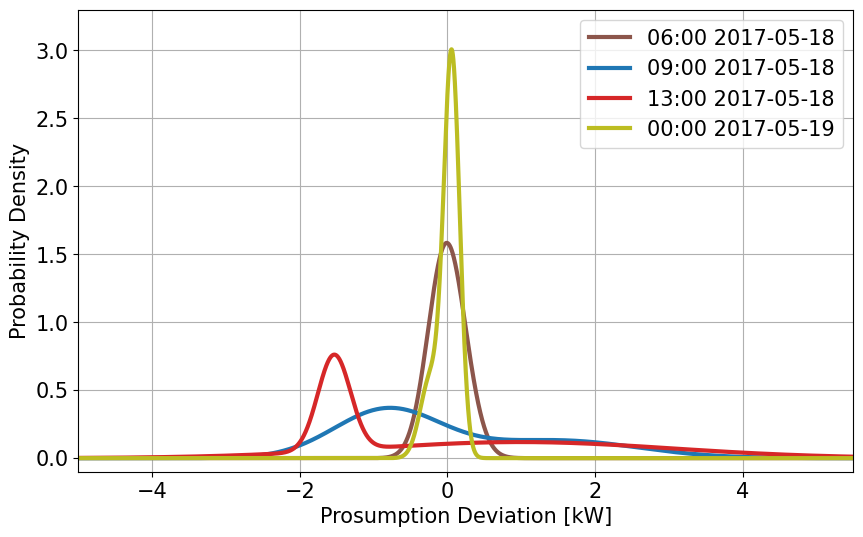

In [8]:
times_to_plot = ['2017-05-18 06:00:00', '2017-05-18 09:00:00', '2017-05-18 13:00:00', '2017-05-19 00:00:00']
fig, ax = plt.subplots(figsize=(10, 6))
x = np.linspace(-6, 6, 10000)
count = 0
colors = ['tab:brown', 'tab:blue', 'tab:red', 'tab:olive']
for t in times_to_plot:
    weights = uncertainty_weights.loc[t]
    y_vals = []
    x_vals_plottable = []
    for xi in x:
        try:
            yi = pdf(xi, *weights)
            y_vals.append(yi)
            x_vals_plottable.append(xi)

        except OverflowError:
            continue
    hours = pd.to_datetime(t).hour
    # reformat hour to 2 digits
    if hours < 10:
        hours = f'0{hours}'
    date = pd.to_datetime(t).date()
    ax.plot(x_vals_plottable, y_vals, linewidth=3, label=f'{hours}:00 {date}', color=colors[count])
    count += 1
plt.grid()
plt.rcParams.update({'font.size': 15})
ax.set_xlim(-5, 5.5)
ax.set_ylim(-0.1, 3.3)
plt.xlabel('Prosumption Deviation [kW]')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

C:\Users\fh6281\AppData\Local\Temp\ipykernel_3316\3426419704.py:30: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



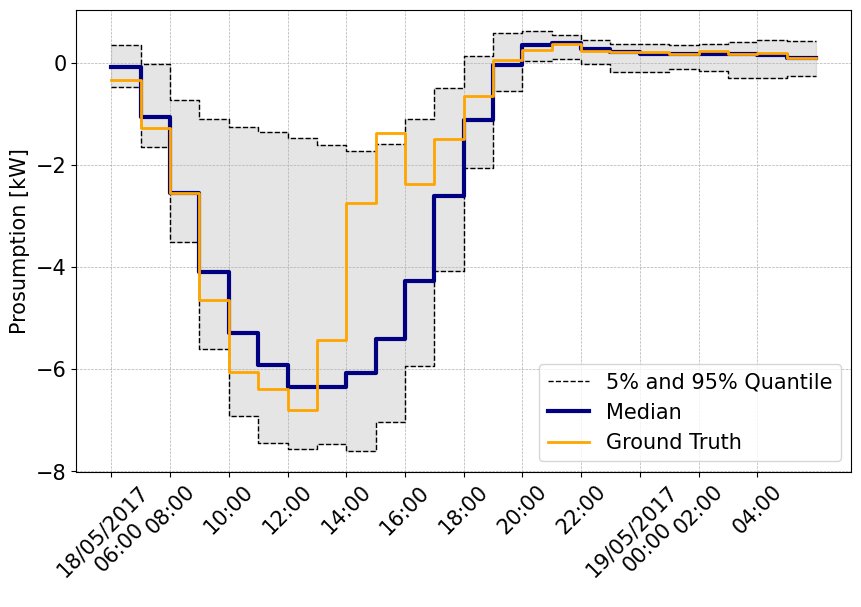

In [9]:
plt.rcParams.update({'font.size': 15})
quantiles = [0.05, 0.95, 0.5]

fig, ax = plt.subplots(figsize=(10, 6))

time = [str(t.hour) for t in fc_exp.index]
time.append(str(int(time[-1])+0.95))  # Repeat the last time point
exp_values = list(fc_exp.values)
exp_values.append(fc_exp.values[-1]) 

gt_values = list(gt.values)
gt_values.append(gt.values[-1])


ordered_time =tuple(fc_exp.index)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: custom_x_axis_formatter(x, pos, ordered_time)))

# Uncertainty band
uncertainty_form = input_data['pdf/cdf name']
uncertainty_weights = input_data['fc_weights']

pdf = pdf_formula(uncertainty_form)
cdf = cdf_formula(uncertainty_form)

x = np.linspace(-15, 15, 10000)
prosumption_quant_low = []
prosumption_quant_high = []
prosumption_quant_mid = []
for i in range(len(uncertainty_weights)):
    w1, w2, w3, w4, w5, w6 = uncertainty_weights[i]

    for xi in x:
        #try:
        cdf_val = cdf(xi, w1, w2, w3, w4, w5, w6)
        if cdf_val >= quantiles[0]:
            prosumption_quant_low.append(xi)
            break

    for xi in reversed(x):
        cdf_val = cdf(xi, w1, w2, w3, w4, w5, w6)
        if cdf_val <= quantiles[1]:
            prosumption_quant_high.append(xi)
            break
    
    if len(quantiles) == 3:
        for xi in x:
            cdf_val = cdf(xi, w1, w2, w3, w4, w5, w6)
            if cdf_val >= quantiles[2]:
                prosumption_quant_mid.append(xi)
                break

if prosumption_quant_mid is not None:
    prosumption_quant_mid.append(prosumption_quant_mid[-1])
prosumption_quant_low.append(prosumption_quant_low[-1])
prosumption_quant_high.append(prosumption_quant_high[-1])
    


# Shift the deviations to the expected prosumption
prosumption_quant_low = exp_values + np.array(prosumption_quant_low)
prosumption_quant_high = exp_values + np.array(prosumption_quant_high)



plt.step(time, prosumption_quant_low, label=f'{int(100*quantiles[0])}% and {int(100*quantiles[1])}% Quantile', color='black', linestyle='--', where='post', linewidth=1.0)
plt.step(time, prosumption_quant_high, color='black', linestyle='--', where='post', linewidth=1.0)
ax.fill_between(time, prosumption_quant_low, prosumption_quant_high, color='grey', alpha=0.2, step='post')

if prosumption_quant_mid is not None:
    prosumption_quant_mid = exp_values + np.array(prosumption_quant_mid)
    plt.step(time, prosumption_quant_mid, label='Median', color='navy', where='post', linewidth=3.0) # f'{int(100*quantiles[2])}% Quantile'


a = list(gt_series.values)
a.append(a[-1])
plt.step(time, a, label='Ground Truth', where='post', linewidth=2, color='orange')

plt.ylabel('Prosumption [kW]')
plt.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0, 24, 2), rotation=45)
#plt.tight_layout()

plt.show()